In [1]:
import os
import numpy as np
import netCDF4 as nc4
import shutil
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from scipy import stats

### 1. Set control variables

In [3]:
doanalysis = 1
paramfileroot='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/'
convgpp = 3600*24*1000 # KgC.m2/s to gc/m2/day
convet=3600*24
#where are we now?
read_params = 1
ncls_pft=3
vars_bm=['ET','GPP','LAI','CUE']
ppe_root='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe'

ensN=18
if ensN == 13:
    ncases=100
    ychoose =29
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=0

if ensN == 17: #nSP LHC
    ncases=50
    ychoose =1996
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=1
    nplot=50
    ens_directory='FATES_NOCOMP_SP_LHC5_BET_'   
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/SP_LHC/sp_lhc_v1_'

if ensN == 18: #BET NOCOMP LHC
    spmode=0
    ncases=100
    ychoose =29
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=1
    nplot=50
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC14_'   
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/SP_LHC/sp_lhc_v1_'  
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v14_'


### Generic paths

In [4]:

pdatafile='parameter_outputs/params_v'+str(ensN)+'.nc'
ldatafile='lai_output_'+str(ensN)+'.nc'
etdatafile='et_output_'+str(ensN)+'.nc'
cuedatafile='cue_output_'+str(ensN)+'.nc'
gppdatafile='gpp_output_'+str(ensN)+'.nc'

vs=range(1,ncases+1) 
figdir = 'figs_ensN_'+str(ensN)

yl=6
USER='rfisher'
output_dir='/glade/derecho/scratch/'+USER+'/'

sgpath='sgmap.nc'
print(ensN, ens_directory)
print(pdatafile)

yr='.clm2.h0.'   

18 FATES_NOCOMP_FBG_PPE_LHC14_
parameter_outputs/params_v18.nc


In [5]:
def make_directory(fileroot):   
    if(os.path.isdir(fileroot)):
        print('dir exists:'+fileroot)
    else:
        os.mkdir(fileroot)
        print('made: '+fileroot)

### ANALYSIS: Choose variables to read in

In [6]:

vars=['FATES_GPP','FATES_NPP','FATES_LAI','FATES_NOCOMP_PATCHAREA_PF','QFLX_EVAP_TOT']
#,'QFLX_EVAP_TOT','FATES_GROWTH_RESP','FATES_LAI_CANOPY_SZ',
 #     'FATES_AREA_PLANTS','FATES_AREA_TREES','FATES_CANOPY_VEGC','FATES_USTORY_VEGC','FATES_TRIMMING','FATES_MAINT_RESP','FATES_LEAFMAINTAR','FATES_VEGC','FATES_VEGC_ABOVEGROUND','FATES_NPLANT_PF','FATES_TRIMMING','lat','lon','time']
 #### ANALYSIS: Make output figure directory
figdir = (os.getcwd() +'/'+ 'figs_'+ens_directory+'/')
make_directory(figdir)

dir exists:/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC14_/


###  2. Make a single data structure for the ensemble

In [7]:
print(read_model_output)
if read_model_output==1:
    print(output_dir,ncases+1)
    vs=range(ncases)
    if doanalysis ==1:
        debug=0
        firstgo=1
        mins_ds=[]
        maxs_ds=[]
        count=1
        missing=range(0,ncases+1)
        missing=np.multiply(missing,0)
        for i in range(1,ncases+1):
            print(i)
            run=ens_directory+str(i)
            print('run',run)
            if(ychoose<10):
                hstring='.clm2.h0.000'
            elif (ychoose<100):
                hstring='.clm2.h0.00'
            elif ychoose<1000:
                hstring='.clm2.h0.0' 
            else:
                hstring='.clm2.h0.' 
            #os.listdir(output_dir + '/archive')
            ahpath = output_dir + 'archive/' + run + '/lnd/hist/' 
            rhpath = output_dir + run + '/run/' 
            
            tfile = run+hstring+str(ychoose)+'-02-01-00000.nc'
            tfileall=tfile
            if(ensN>=14):
                tfile = run+hstring+str(ychoose)+'-02.nc' 
                tfileall= run+hstring+str(ychoose)+'-*.nc' 
                
            missing[i]=1
            #if(os.path.isdir(hpath)): ! #there is an archive
            if(os.path.isfile(rhpath+tfile)):  # this years is in the archive. 
                hpath = rhpath
                if debug == 1 :print('file in archive',rhpath)
                missing[i]=0
            else:
                if debug == 1 :print('file not in archive. try rundir')                
                hpath = ahpath       
                if(os.path.isdir(hpath)): 
                    #print('there is a rundir',hpath+tfile)                
                    if(os.path.isfile(hpath+tfile)):
                        if debug == 1 :print('file in  rundir')
                        missing[i]=0
                    else:
                        print('no file in rundir',hpath+tfile)
                else:
                    print('there is no  rundir',hpath+tfile)
                    
            if(missing[i]==0): # the year can be found. 
                rt=hpath+run+yr+str(ychoose)+'*'
                rt=hpath+tfileall
                outf=hpath+'cat_file_'+str(i)+'.nc'
                print('rt',rt)
                !rm $outf
                !ncrcat $rt $outf

                if(firstgo==1):
                    tmp = xr.open_mfdataset(rt, decode_times=False)  
                    allvars=list(xr.open_dataset(hpath+tfile, decode_times=False).variables)
                    dropvars=list(set(allvars) - set(vars)) 
                    firstgo=0
                
                tmp=xr.open_mfdataset(outf, decode_times=False, drop_variables=dropvars)
               
            else:
                print('MISSING INPUT')
              
            if i==1:
                try: 
                    del dsc
                except:
                    print('no dsc')
                dsc = tmp.load()           
            else:
                dsc=xr.concat([dsc,tmp],'ens')
    
    print('end')
else:
    print('not reading model output')

1
/glade/derecho/scratch/rfisher/ 101
1
run FATES_NOCOMP_FBG_PPE_LHC14_1
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_1/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_1.clm2.h0.0029-*.nc
no dsc
2
run FATES_NOCOMP_FBG_PPE_LHC14_2
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_2/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_2.clm2.h0.0029-*.nc
3
run FATES_NOCOMP_FBG_PPE_LHC14_3
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_3/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_3.clm2.h0.0029-*.nc
4
run FATES_NOCOMP_FBG_PPE_LHC14_4
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_4/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_4.clm2.h0.0029-*.nc
5
run FATES_NOCOMP_FBG_PPE_LHC14_5
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_5/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_5.clm2.h0.0029-*.nc
6
run FATES_NOCOMP_FBG_PPE_LHC14_6
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_FBG_PPE_LHC14_6/lnd/hist/FATES_NOCOMP_FBG_PPE_LHC14_6.c

### 3 Read parameter files into a list. 

In [8]:
if(read_params==1):
    vsp=range(1,ncases+1) 
    print(pfileroot)
    paramsp=['not found'] * 100
    if doanalysis ==1:
        # loop round whole ensemble
        for i in vsp: 
            pfile1= xr.open_dataset(pfileroot+str(i)+'.nc')  
            print(np.shape(pfile1.fates_leaf_slatop),pfile1.fates_leaf_slatop[0].values)
            if i==vsp[0]:
                try: 
                    del dsc_params
                except:
                    print('no dsc')
                all_param_data = pfile1                      
            else:
                all_param_data=xr.concat([all_param_data, pfile1], "ens")  
                 # Close the file
            pfile1.close()
else:
    print('readging existing param file: ',pdatafile)
    all_param_data= xr.open_dataset(pdatafile) 
    

#### Write parameter output file

if(read_params==1):
    try:
        os.remove(pdatafile)
    except:
        print('no pfile')
        
    all_param_data.to_netcdf(pdatafile)  
 

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v14_
(12,) 0.011856
no dsc
(12,) 0.015216
(12,) 0.012384000000000001
(12,) 0.01272
(12,) 0.015408000000000002
(12,) 0.015456000000000001
(12,) 0.013968000000000001
(12,) 0.013920000000000002
(12,) 0.014832000000000001
(12,) 0.012
(12,) 0.012336000000000001
(12,) 0.014256000000000001
(12,) 0.011328000000000001
(12,) 0.0132
(12,) 0.015552
(12,) 0.015072000000000002
(12,) 0.01464
(12,) 0.011472000000000001
(12,) 0.013248000000000001
(12,) 0.012528000000000001
(12,) 0.012816000000000001
(12,) 0.011664
(12,) 0.01344
(12,) 0.014016
(12,) 0.014064
(12,) 0.015360000000000002
(12,) 0.014736
(12,) 0.013536000000000001
(12,) 0.011376
(12,) 0.012960000000000001
(12,) 0.013008
(12,) 0.011136
(12,) 0.013632000000000002
(12,) 0.013824000000000001
(12,) 0.012576
(12,) 0.012672000000000001
(12,) 0.010848
(12,) 0.012048000000000001
(12,) 0.01488
(12,) 0.010944
(12,) 0.01468800

#### 4. Find modified parameters

In [9]:
directory_path = pfileroot
data1= xr.open_dataset(pfileroot+str(1)+'.nc') 
data2= xr.open_dataset(pfileroot+str(3)+'.nc') 
common_variables = set(data1.variables) & set(data2.variables)
print(data1.fates_leaf_slatop[0].values,data2.fates_leaf_slatop[0].values)
# Iterate through the common variables and compare their values
parlist=[]
for var_name in common_variables:
    var_data1 = data1[var_name]
    var_data2 = data2[var_name]
    # Compare the values of the variables
    if not var_data1.equals(var_data2):
        parlist.append(var_name)

lhc_vars=parlist
print(lhc_vars)

lhc_vars_title=np.copy(lhc_vars)
for i, var in enumerate(lhc_vars):
    
    original_string =var
    substring_to_remove = "fates_"
    lhc_vars_title[i] = var.replace(substring_to_remove, "")


0.011856 0.012384000000000001
['fates_maintresp_leaf_vert_scaler_coeff2', 'fates_allom_d2ca_coefficient_min', 'fates_turnover_leaf', 'fates_leaf_slatop', 'fates_allom_d2bl1']


### 5. Find parameter ranges

In [10]:
pchoose=0
ensn=all_param_data.dims['ens']
x_array = np.zeros((ensn,len(parlist)))
plhc=all_param_data[parlist]
for i, var in enumerate(parlist):
    print(var)
    nd=all_param_data[var].ndim
    dnames=all_param_data[var].dims
    print(np.shape(all_param_data[var] ))
    if(nd==1):
        param_mean=all_param_data[var] 
    elif nd==2:
        param_mean=all_param_data[var][:,pchoose]
    elif nd==3:
        param_mean=all_param_data[var][:,0,pchoose]
    print(np.shape(param_mean))
       # param_mean=param_mean.mean(dnames[1])
    x_array[:, i] = param_mean
    print('i=',i,var,x_array[1:4,i])

fates_maintresp_leaf_vert_scaler_coeff2
(100, 12)
(100,)
i= 0 fates_maintresp_leaf_vert_scaler_coeff2 [1.8468  0.66096 2.11896]
fates_allom_d2ca_coefficient_min
(100, 12)
(100,)
i= 1 fates_allom_d2ca_coefficient_min [0.13036277 0.23030756 0.11080835]
fates_turnover_leaf
(100, 1, 12)
(100,)
i= 2 fates_turnover_leaf [1.55 1.52 1.69]
fates_leaf_slatop
(100, 12)
(100,)
i= 3 fates_leaf_slatop [0.015216 0.012384 0.01272 ]
fates_allom_d2bl1
(100, 12)
(100,)
i= 4 fates_allom_d2bl1 [0.06084 0.06768 0.072  ]


### 6 write LAI output file

In [11]:

if(read_model_output==1):
    try:
        os.remove(ldatafile)
    except:
        print('no lfile')
    try:
        os.remove(etdatafile)
    except:
        print('no etfile')
    try:
        os.remove(gppdatafile)
    except:
        print('no gppfile')
    try:
        os.remove(cuedatafile)
    except:
        print('no cuefile')
              
if(read_model_output==1):
    etmatrix=(dsc['QFLX_EVAP_TOT'].mean('time') )
    etmatrix.to_netcdf(etdatafile)
### calculate and write CUE
if(read_model_output==1):
    print(ldatafile)
    laimatrix=(dsc['FATES_LAI'].mean('time') )
    laimatrix.to_netcdf(ldatafile)  
if(read_model_output==1):
    print(ldatafile)
    gppmatrix=(dsc['FATES_GPP'].mean('time') )
    gppmatrix.to_netcdf(gppdatafile) 
if(spmode==0):
    print(ldatafile)
    cuematrix=np.divide(dsc['FATES_NPP'].mean('time'),dsc['FATES_GPP'].mean('time') )
    cuematrix.to_netcdf(cuedatafile) 

cuein=xr.open_dataset(cuedatafile)
l=xr.open_dataset(ldatafile)
gpp_in=xr.open_dataset(gppdatafile)
gpp_in=np.multiply(gpp_in,convgpp)
et_in=xr.open_dataset(etdatafile)
et_in=np.multiply(et_in,convet)

lai_output_18.nc
lai_output_18.nc
lai_output_18.nc


### Find the values for the meshfile gridpoints in the ILAMB data

In [12]:
gppfile_m='/glade/work/rfisher/ILAMB_data/DATA/gpp/FLUXCOM/gpp.nc'
gppfile_w='/glade/work/rfisher/ILAMB_data/DATA/gpp/WECANN/gpp.nc'
laifile='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/lai/MODIS/lai_0.5x0.5.nc'
etfile='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/evspsbl/GLEAMv3.3a/et.nc'

In [13]:
#open ilamb data. 
ds_gpp_m = xr.open_dataset(gppfile_m)
ds_gpp_w = xr.open_dataset(gppfile_w)
ds_lai = xr.open_dataset(laifile)
ds_et = xr.open_dataset(etfile)
ds_gpp_m=ds_gpp_m.mean('time')
ds_gpp_w=ds_gpp_w.mean('time')
ds_lai=ds_lai.mean('time')
ds_lai['lat']=ds_lai.lat*-1
ds_et=ds_et.mean('time')
ds_et=ds_et*convet

### Find and open mesh file

In [14]:
meshfile='/glade/work/afoster/FATES_calibration/mesh_files/broadleaf_evergreen_tropical_tree_grid_presence_mesh.nc'
mesh=xr.open_dataset(meshfile)
latlon=mesh.where(mesh.elementMask == 1, drop=True).centerCoords.values

### Convert the longitudes in the mesh file from 0-360 space to -180 to 180 space to be comparable to the ILAMB data files

In [15]:
lat_mesh=latlon[:,1]
lon_mesh=latlon[:,0]
lat_list=lat_mesh
lon_list=lon_mesh
npoints=len(lon_list)
for i in range(npoints):
    if(lon_list[i]>180):        
        lon_list[i]=(360-lon_list[i])*-1

### Extract the GPP and ET and LAI values for the lat lons in the mesh file

In [16]:
Xarr_lat_gpp = ds_gpp_m['lat']
Xarr_lon_gpp = ds_gpp_m['lon']
Xarr_lat_et = ds_et['lat']
Xarr_lon_et = ds_et['lon']
ds_lai['lat']=-ds_lai['lat']
Xarr_lat_lai = ds_lai['lat']
Xarr_lon_lai = ds_lai['lon']

gpp_SG=np.zeros(len(lat_list))
et_SG=np.zeros(len(lat_list))
lai_SG=np.zeros(len(lat_list))

for i in range(len(lat_list)):
    nearest_index_lat = np.abs(Xarr_lat_gpp - lat_list[i]).argmin()
    nearest_index_lon = np.abs(Xarr_lon_gpp - lon_list[i]).argmin()
    gpp_SG[i]=ds_gpp_m['gpp'][nearest_index_lat,nearest_index_lon]

    nearest_index_lat_et = np.abs(Xarr_lat_et - lat_list[i]).argmin()
    nearest_index_lon_et = np.abs(Xarr_lon_et - lon_list[i]).argmin()
    et_SG[i]=ds_et['et'][nearest_index_lat_et,nearest_index_lon_et]

    nearest_index_lat_lai = np.abs(Xarr_lat_lai - lat_list[i]).argmin()
    nearest_index_lon_lai = np.abs(Xarr_lon_lai - lon_list[i]).argmin()
    lai_SG[i]=ds_lai['lai'][nearest_index_lat_lai,nearest_index_lon_et]


### Plot out the ILAMB SG datapoints. 

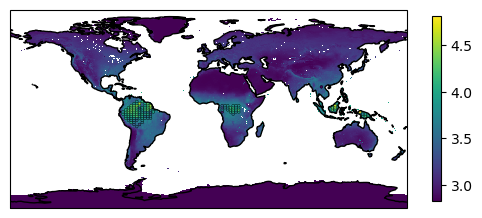

In [17]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ds_et.et.plot(ax=ax, transform=ccrs.PlateCarree(),  vmin=0,vmax=8, cmap='viridis',add_colorbar=False)
scatter = ax.scatter(latlon[:,0], latlon[:,1], c=et_SG, cmap='viridis', marker='o', s=4, edgecolor='black',linewidth=0.3,transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, shrink=0.5)
plt.show()

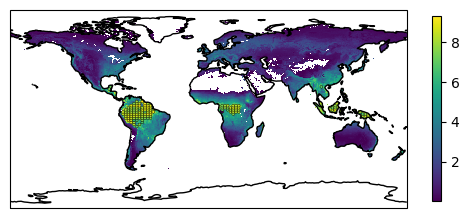

In [18]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ds_gpp_m.gpp.plot(ax=ax, transform=ccrs.PlateCarree(),  vmin=0, cmap='viridis',add_colorbar=False)
scatter = ax.scatter(latlon[:,0], latlon[:,1], c=gpp_SG, cmap='viridis', marker='o', s=4, edgecolor='black',linewidth=0.3,transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, shrink=0.5)
plt.show()

### 8. Read in gridcells dominated by each PFT

In [19]:
pfts=[0]
gcells_pft=[]
gcells_pft.append( range(npoints))
print(gcells_pft[0])

range(0, 125)


### Plot the ET ensemble per PFT

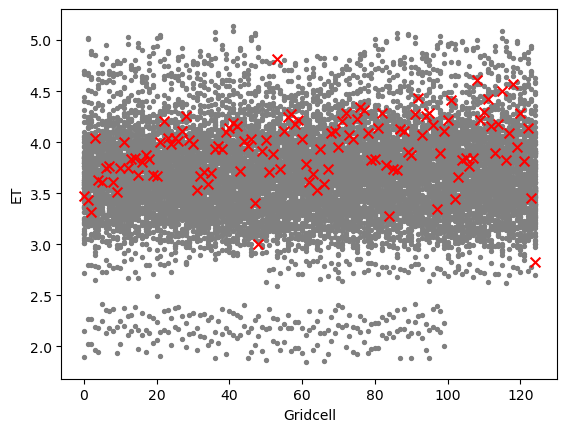

In [20]:
plot_range=1
p=0
if(plot_range==1): 
    fig = plt.figure()    
    etens=et_in.QFLX_EVAP_TOT
    etens_s = np.swapaxes(etens, 0, 1)      
    gcells=gcells_pft[p]

    xvar = [list(range(len(gcells))) for _ in range(len(etens))]
    plt.scatter(xvar,etens_s,color='grey',s=8)
    plt.scatter(range(len(gcells)), et_SG,color='red',s=50,marker='x')        
    plt.ylabel('ET')
    plt.xlabel('Gridcell')

plt.savefig(figdir+'/range_vs_data_et_'+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
plt.show()

### Plot the GPP space per PFT

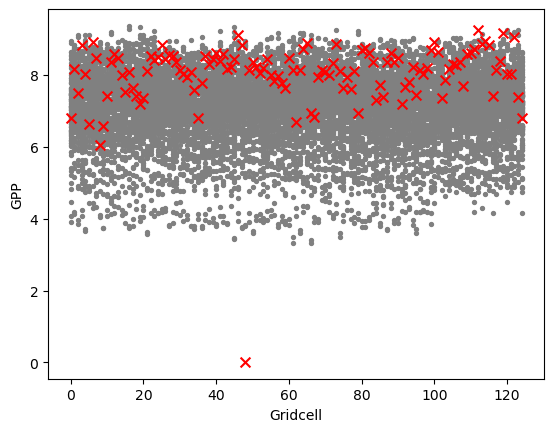

In [21]:
if(plot_range==1): 
    fig = plt.figure()    
    gppens=gpp_in.FATES_GPP
    gppens_s = np.swapaxes(gppens, 0, 1)     
    gcells=gcells_pft[p]
    if len(gcells) >0 :
        xvar = [list(range(len(gcells))) for _ in range(len(gppens))]
        plt.scatter(xvar,gppens_s[gcells,:],color='grey',s=8)
        plt.scatter(range(len(gcells)),gpp_SG,color='red',s=50,marker='x')        
        #plt.set_ylabel('ET', fontsize=26) 
        #plt.set_ylim([0,6]) 
        plt.ylabel('GPP')
        plt.xlabel('Gridcell')
        #plt.set_xlabel('Gridcell', fontsize=20)

plt.savefig(figdir+'/range_vs_data_gpp_'+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
plt.show()

### Plot the CUE space per PFT

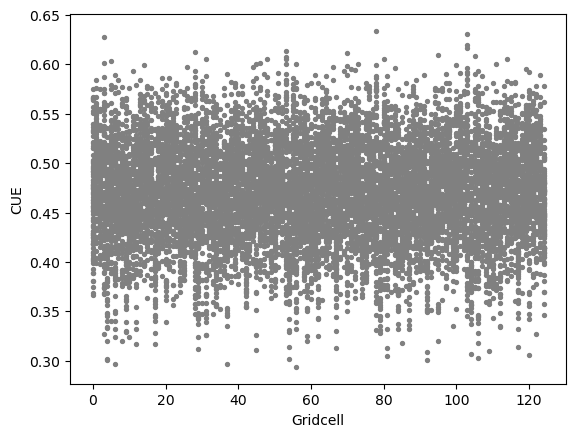

In [22]:
if(plot_range==1): 
    fig = plt.figure()    
    cue_ens=cuein.FATES_NPP
    cueens_s = np.swapaxes(cue_ens, 0, 1)     
    gcells=gcells_pft[p]
    if len(gcells) >0 :
        xvar = [list(range(len(gcells))) for _ in range(len(gppens))]
        plt.scatter(xvar,cueens_s[gcells,:],color='grey',s=8)
        #plt.scatter(range(len(gcells)),gpp_SG,color='red',s=50,marker='x')        
        #plt.set_ylabel('ET', fontsize=26) 
        #plt.set_ylim([0,6]) 
        plt.ylabel('CUE')
        plt.xlabel('Gridcell')
        #plt.set_xlabel('Gridcell', fontsize=20)

plt.savefig(figdir+'/range_vs_data_cue_'+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
plt.show()

### Plot the LAI ensemble space

(125, 100)
minmaxmean <xarray.DataArray 'FATES_LAI' ()>
array(2.16502939) <xarray.DataArray 'FATES_LAI' ()>
array(4.44214862)
minmax <xarray.DataArray 'FATES_LAI' ()>
array(1.505273) <xarray.DataArray 'FATES_LAI' ()>
array(6.11368956)


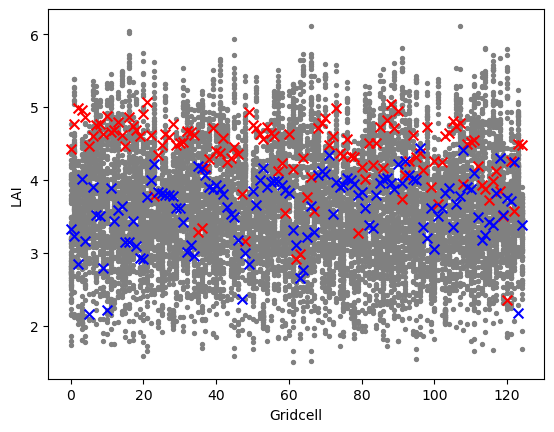

In [23]:
if(plot_range==1): 
    fig = plt.figure()    
    laiens=l.FATES_LAI
    laiens_s = np.swapaxes(laiens, 0, 1)   
    print(np.shape(laiens_s))
    print('minmaxmean',np.min(np.mean(laiens_s,1)),np.max(np.mean(laiens_s,1)))
    gcells=gcells_pft[p]
    print('minmax',np.min(laiens_s),np.max(laiens_s))
    if len(gcells) >0 :
        xvar = [list(range(len(gcells))) for _ in range(len(gppens))]
        plt.scatter(xvar,laiens_s,color='grey',s=8)
        plt.scatter(range(len(gcells)),lai_SG,color='red',s=50,marker='x')        
        plt.scatter(range(len(gcells)),np.mean(laiens_s,1),color='blue',s=50,marker='x')        

        plt.ylabel('LAI')
        plt.xlabel('Gridcell')
plt.savefig(figdir+'/range_vs_data_gpp_'+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
plt.show()

### Find mean LAI, GPP, ET per PFT

In [24]:
pfts=[0]
et_pft=np.zeros(max(pfts)+1)
lai_pft=np.zeros(max(pfts)+1) 
gbaf_gpp_pft=np.zeros(max(pfts)+1)
p=0
et_pft[p]=np.mean(et_SG)
gbaf_gpp_pft[p]=np.mean(gpp_SG)
lai_pft[p]=np.mean(lai_SG)

### Find mean CUE PFT

In [25]:
### Find mean CUE per PFT
cue_pft_mean=np.zeros(max(pfts)+1)
cue_pft_std=np.zeros(max(pfts)+1)
for p in pfts: # pfts to select. 
    gcells=gcells_pft[p]
    cue_pft_mean[p]=0.46
    cue_pft_std[p]=0.11

cue_pft_mean[0]=0.44
#cue_pft_mean[1]=0.45
#cue_pft_mean[2]=0.44

print(cue_pft_mean)
# EBT 0.44 ± 0.11
# DBT 0.50 ± 0.13  

[0.44]


In [26]:
### 10 Deal with any nans in the model output

nan_indices = l.FATES_LAI.isnull().any(dim='ens')

# Use the where method to filter out NaNalues along the 'time' dimension
filtered_data = l.FATES_LAI.where(~nan_indices, drop=True)
lnonan=filtered_data.fillna(999)
lnonan=l.FATES_LAI
cnonan=cuein.FATES_NPP
gnonan=gpp_in.FATES_GPP
enonan=et_in.QFLX_EVAP_TOT

In [27]:
### 11.  Make Function to map out parameter space
def map_param_space(g,vnonan):
    ncls=ncls_param
    rw=int(len(lhc_vars)/ncls)+1

    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(27, 16))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    fig.suptitle('Impacts of parameter variation' ,y=0.93, fontsize=26)
    p=-1
    axcount=0
    
    X=x_array 
    yall=vnonan[:,g]
    yall=yall[0:len(x_array)]   
    
    print(yall.shape,np.shape(x_array))
    
    for i, var in enumerate(parlist):
        p=p+1
     #   print(p)
        row = axcount //ncls
        col = axcount % ncls        
        axcount=axcount+1    
        #print(np.shape(paramv), fates_output_data.shape)
        axes[row, col].set_title(var,fontsize=20)    
        diffplot=axes[row, col].scatter(x_array[:,i],yall)
        if(row>1):
            axes[row, col].set_yticklabels([], fontsize=18) 
        if(col>1):
            axes[row, col].set_yticklabels([], fontsize=18) 
        #axes[row, col].set_ylim([0,yl]) 
    while axcount < rw*ncls:
        row = axcount //ncls
        col = axcount %ncls
        axes[row, col].remove()
        axcount += 1
    
    plt.savefig(figdir+'x_vs_y'+'_y'+str(ychoose)+'_g'+str(g)+'.png',bbox_inches='tight')  
    plt.show()
### 13. Make different types of statistical model  

### 13.1 Random forest

In [28]:

# Load a sample dataset (Boston housing dataset)
def random_forest(g,fgs,feat, multp,vnonan):
    yall=vnonan[:,g]

    if np.ndim(yall)==2:     
        yall=np.mean(yall,1)
    nan_indices = yall.isnull()
    yall[np.isnan(yall)] = np.mean(yall)
    yall=yall[0:len(x_array)]
    X=x_array[0:len(yall),:]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    mask = np.where(np.isinf(y_train))
    y_train[mask]=0.5
    # Create a random forest regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    print(vars_bm[v],'min,max',np.min(yall).values,np.max(yall).values)
    # Fit the model to the training data
    rf_model.fit(X_train, y_train)
    rf_models.append(rf_model)

    # Make predictions on the testing data
    y_pred = rf_model.predict(X_test)
    if(fgs==1 ):
        #if(multp==1):
        
        #else:
           # print(col)
            #ax=axes[col]
       # map_param_space(g)
        #fig = plt.figure()
        plt.scatter(y_test,y_pred,color='blue',s=20,label='Random Forest')
        plt.plot([min(y_pred),max(y_pred)],[min(y_pred),max(y_pred)],color='black')
            #plt.scatter(tr_predictions,y)
        #axes[row,col].title('g='+str(g)+' Lat:'+str(round(glat[g], 2))+' Lon:'+str(round(glon[g], 2)))

        plt.xlabel(vars_bm[v]+' process model')
        plt.ylabel(vars_bm[v]+' surrogate')
    r_squared = stats.pearsonr(y_pred, y_test)[0] ** 2
    if(feat==1):
        feature_importances = rf_model.feature_importances_
    
    # Create a DataFrame to display the feature importances
        #feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        #feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
        feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances})
        feature_importances_df['FeatureIndex'] = range(0, len(feature_importances_df) )

        feature_importances_df = feature_importances_df.sort_values(by='Feature Importance', ascending=False)
    
        # Display the dominant factors
        #print(feature_importances_df.FeatureIndex.iloc[1:4])
        featimp=feature_importances_df.FeatureIndex.iloc[0:4]
    return r_squared,featimp

### 13.2 Linear Regression

In [29]:

def linear_regression(g,fgs, axes, row, col,vnonan):
    yall=vnonan[:,g]
    if np.ndim(yall)==2:   
        yall=np.mean(yall,1)
    nan_indices = yall.isnull()
    yall[np.isnan(yall)] = np.mean(yall)   
    X=x_array
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    
    model = sm.OLS(y_train, X_train).fit()  # Fit the multivariate linear regression model
   # print(model.summary())
    predictions = model.predict(X_test)
    tr_predictions = model.predict(X)
    if(fgs==1):
        #map_param_space(g)
        axes[row,col].scatter(y_test,predictions,color='green',label='Linear Regression')
        #plt.scatter(tr_predictions,y)
    residuals = model.resid

# Calculate the standard deviation of predictions
  #  std_dev_predictions = residuals.std()
  #  rel_dev=np.divide(std_dev_predictions,np.mean(y))

    r_squared = stats.pearsonr(predictions, y_test)[0] ** 2
    return r_squared
    

### 13.3 Gaussian Process emulator

In [30]:

def make_emulator_for_point(g,fgs, axes, row, col,vn):
    yall=vn[:,g]

    if np.ndim(yall)==2:     
        yall=np.mean(yall,1)
    nan_indices = yall.isnull()
    yall[np.isnan(yall)] = np.mean(yall)
    yall=yall[0:len(x_array)]
    X=x_array[0:len(yall),:]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    mask = np.where(np.isinf(y_train))
    y_train[mask]=0.5    
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    y_pred =gp.fit(X_train, y_train)
    test_prediction, std_prediction = gp.predict(X_test, return_std=True)
    #r2 = r2_score(ytest, test_prediction) 
    
    if(np.max(test_prediction)==0):
        print('emulator fail')
    else:
        print('mean pred',np.mean(test_prediction))
    

    if(fgs==1 ):
        if(multp==1):
            ax=axes[row,col]
        else:
            ax=axes
            
        ax.scatter(y_test,test_prediction, color='red', marker='o',label='GP emulator')
        ax.legend(loc='upper left')
        #ax.scatter(test_prediction,ytest)
        #ax.set_xlabel('LAI emulator')
        #ax.set_ylabel('LAI FATES')

    r_squared = stats.pearsonr(test_prediction, y_test)[0] ** 2
    return r_squared
    

### 14.  Run emulators

(125, 100)
minmaxmean <xarray.DataArray 'QFLX_EVAP_TOT' ()>
array(2.05077482) <xarray.DataArray 'QFLX_EVAP_TOT' ()>
array(4.82588782)
p,i 0 0
0.0
ET min,max 3.3581564130109776 3.881200711551137


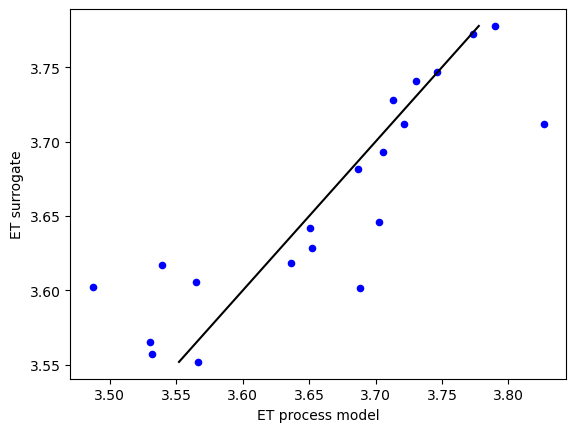

(125, 100)
minmaxmean <xarray.DataArray 'FATES_GPP' ()>
array(3.99158514) <xarray.DataArray 'FATES_GPP' ()>
array(8.74375451)
p,i 0 0
0.0
GPP min,max 6.096756759763186 7.7254430220341135


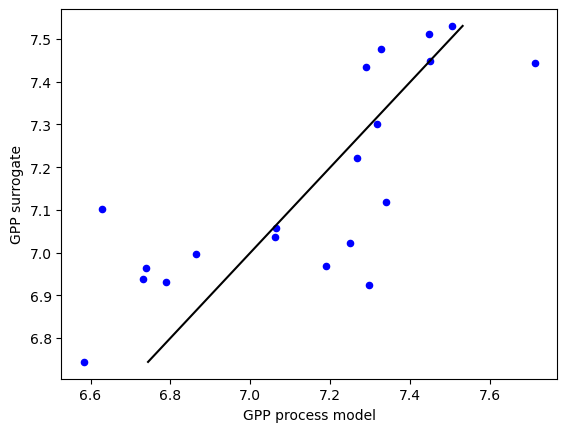

(125, 100)
minmaxmean <xarray.DataArray 'FATES_LAI' ()>
array(2.16502939) <xarray.DataArray 'FATES_LAI' ()>
array(4.44214862)
p,i 0 0
0.0
LAI min,max 2.1207968492917066 4.9404179692921755


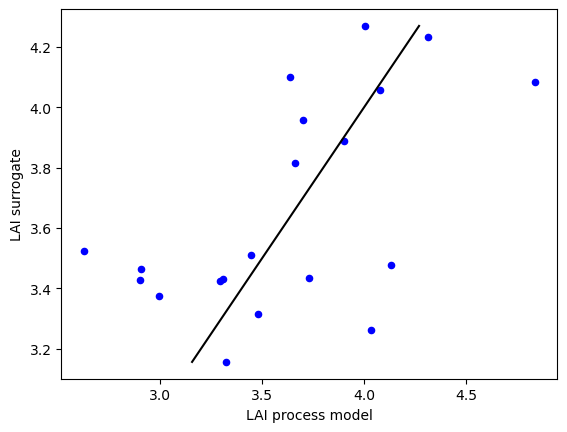

(125, 100)
minmaxmean <xarray.DataArray 'FATES_NPP' ()>
array(0.38520875) <xarray.DataArray 'FATES_NPP' ()>
array(0.56693989)
p,i 0 0
0.0
CUE min,max 0.40177506291743564 0.5511192787704959


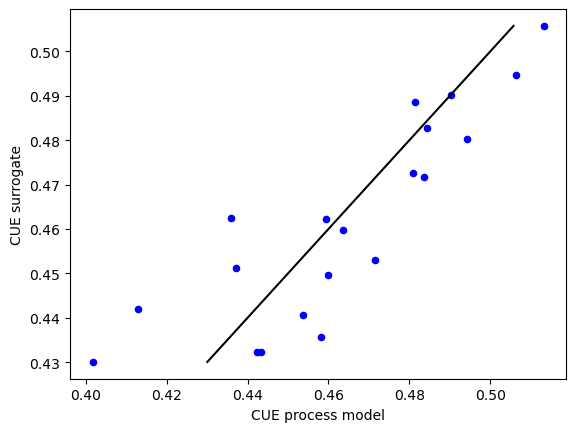

In [31]:
# Make empty lists for statistical models
rf_st=np.zeros(355)
lr_st=np.zeros(355)
gp_st=np.zeros(355)
import pandas as pd
ncls=ncls_pft
rw=int(len(gcells)/ncls)+1
feat_importance = np.zeros([len(pfts),4,4], dtype=int)
vnonan=[enonan,gnonan,lnonan,cnonan]
for v, vn in enumerate(vnonan): 

    laiens=vn
    laiens_s = np.swapaxes(laiens, 0, 1)   
    print(np.shape(laiens_s))
    print('minmaxmean',np.min(np.mean(laiens_s,1)),np.max(np.mean(laiens_s,1)))

    fig = plt.figure() 
    multp=0
    rf_models = []
    rf_st=np.zeros(max(pfts)+1)
    axcount=0
    for i in range(len(pfts)):
        
        p=pfts[i]
        print('p,i',p,i)
        row = axcount //ncls
        col = axcount % ncls   
        axcount=axcount+1
        #rf_st[i],feat_importance[i,:,v]=
        print(rf_st[i])
        rf_st[i],feat_importance[i,:,v]=random_forest(gcells_pft[p],1,1,multp,vn)
        #make_emulator_for_point(gcells_pft[p],1, axes, row, col,vn)

        #axes[row,col].set_xlabel(vars_bm[v]+' process model',fontsize=16)
        #axes[row,col].set_ylabel(vars_bm[v]+' surrogate',fontsize=16)
        #axes[row,col].set_title(sg_data['pft'].values[p].title(),fontsize=16)
    
    plt.savefig(figdir+'/PFT_level_RF_fit_'+vars_bm[v]+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
    plt.show()
    if(v==0):        
        rf_models_et = rf_models
    elif v==1:
        rf_models_gpp = rf_models
    elif v==2:
        rf_models_lai = rf_models
    else:
        rf_models_cue = rf_models
       


### 14.3 Plot gridcell specific emulators (for a given PFT) in differenet subplots


In [32]:
plot_gcell_fit=0
target_pft=0
vnonan=enonan
if plot_gcell_fit==1 :
    multp=0
    ncls=3
    rw=int(len(gcells)/ncls)+1
    print(rw)
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(27, 21))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    
    do_all_models=1
    if(do_all_models==1):
        rf_models = []
        feat_importance = np.zeros([355,4,2], dtype=int)
        axcount=0
        for g in gcells:
            row = axcount //ncls
            col = axcount % ncls   
            axcount=axcount+1
            rf_st[g],feat_importance[g,:,v]=random_forest(g,1,1, axes, row, col,multp,vnonan)
            lr_st[g]=linear_regression(g,1, axes, row, col)
            gp_st[g]=make_emulator_for_point(g,1, axes, row, col)
            print('g='+str(g),'rf:',rf_st[g],'l1:',lr_st[g],'gp:',gp_st[g])
        plt.savefig(figdir+'/emulator_test_'+str(ensN)+'_'+'_p'+str(p)+'.png', bbox_inches='tight')
        plt.show()

    else:
        rf_models = []
        feat_importance = np.zeros([355,4], dtype=int)
        for g in gcells:
            rf_st[g],feat_importance[g,:]=random_forest(g,0,1)
            print(feat_importance[g,:],lhc_vars[feat_importance[g,0]],
                 lhc_vars[feat_importance[g,1]],
                 lhc_vars[feat_importance[g,2]])
    

In [33]:
### 15. Make a large hypercube encompassing the whole parameter space 
num_samples=5000
num_variables = len(lhc_vars)
hypercube = np.zeros((num_samples, num_variables))
for i in range(num_variables):
    hypercube[:, i] = np.random.permutation(np.linspace(0, 1, num_samples))

hypercube_scaled=np.zeros((num_samples, num_variables))
#for i  in range(5):
for i, var in enumerate(lhc_vars):
    mx=np.max(x_array[:,i])
    mn=np.min(x_array[:,i])
    print(var,mn,mx)
    for e in range(num_samples):
        hypercube_scaled[e,i]=(hypercube[e,i]*(mx-mn))+mn
Xdense=hypercube_scaled
print('hypercube shape',np.shape(Xdense))
### 16 Find simulations with acceptable LAI and CUE
y_pred_noise_i_lai = []
y_pred_noise_i_et = []
y_pred_noise_i_gpp = []
y_pred_noise_i_cue = []
for i in range(len(pfts)):
    g=gcells[i]     
    y_pred_noise_i_lai.append(rf_models_lai[i].predict(Xdense))
    y_pred_noise_i_et.append(rf_models_et[i].predict(Xdense))
    y_pred_noise_i_gpp.append(rf_models_gpp[i].predict(Xdense))
    y_pred_noise_i_cue.append(rf_models_cue[i].predict(Xdense))

print(np.shape(y_pred_noise_i_lai))

fates_maintresp_leaf_vert_scaler_coeff2 0.48600000000000004 2.43
fates_allom_d2ca_coefficient_min 0.05431782000000001 0.2715891
fates_turnover_leaf 1.0 2.0
fates_leaf_slatop 0.0108 0.015600000000000001
fates_allom_d2bl1 0.036000000000000004 0.07200000000000001
hypercube shape (5000, 5)
(1, 5000)


### Find acceptable models

In [34]:
   
def find_acceptable_models(rfm,p,pftfit,vartoggle,fates_ens,fates_or_surrogate):
    fates_ens_mean=fates_ens.mean('gridcell')
    fates_ens_mean.plot() 
    print('fatesens',np.shape(fates_ens),np.shape(fates_ens_mean),fates_ens.dims)
    if vartoggle==0:
        y_pred_noise=y_pred_noise_i_et[rfm]
        etmin=et_pft[p]-0.1*et_pft[p]
        etmax=et_pft[p]+0.1*et_pft[p]
        print('et minmax',np.min(y_pred_noise),np.max(y_pred_noise))
        y_accept=np.where(np.logical_and(y_pred_noise>=etmin, y_pred_noise<=etmax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=etmin, fates_ens_mean<=etmax))  
        print('et range',etmin,etmax,np.shape(y_accept))
    elif vartoggle==1:
        y_pred_noise=y_pred_noise_i_gpp[rfm]
        gppmin=gbaf_gpp_pft[p]-0.1*gbaf_gpp_pft[p]
        gppmax=gbaf_gpp_pft[p]+0.1*gbaf_gpp_pft[p]
        y_accept=np.where(np.logical_and(y_pred_noise>=gppmin, y_pred_noise<=gppmax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=gppmin, fates_ens_mean<=gppmax))  
        print('gpprange',gppmin,gppmax,np.shape(y_accept))
    elif(vartoggle==2): 
        y_pred_noise=y_pred_noise_i_lai[rfm]
        if(pftfit==1):
            ldmin=lai_pft[p]-0.1*lai_pft[p]
            ldmax=lai_pft[p]+0.1*lai_pft[p]
        y_accept=np.where(np.logical_and(y_pred_noise>=ldmin, y_pred_noise<=ldmax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=ldmin, fates_ens_mean<=ldmax))  
        print('lai range',p,ldmin,ldmax,np.shape(y_accept))
        print('lai range emul',p,np.min(y_pred_noise),np.max(y_pred_noise),np.shape(y_accept))
    elif vartoggle==3:
        y_pred_noise=y_pred_noise_i_cue[rfm]
        cuemin=cue_pft_mean[p]-0.5*cue_pft_std[p]
        cuemax=cue_pft_mean[p]+0.5*cue_pft_std[p]  
        y_accept=np.where(np.logical_and(y_pred_noise>=cuemin, y_pred_noise<=cuemax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=cuemin, fates_ens_mean<=cuemax))  
        print('cuerange',cuemin,cuemax,np.shape(y_accept))

    if(fates_or_surrogate==0):
        return y_accept_ens
    else:
        return y_accept

pft 0
fatesens (100, 125) (100,) ('ens', 'gridcell')
et minmax 3.463102496975891 3.844573702973355
et range 3.5398567573717794 4.326491592343286 (1, 4954)
fatesens (100, 125) (100,) ('ens', 'gridcell')
gpprange 7.226005188330262 8.83178411907032 (1, 1829)
fatesens (100, 125) (100,) ('ens', 'gridcell')
lai range 0 3.926839631080627 4.799470660209655 (1, 1300)
lai range emul 0 2.657167257660433 4.497467370624025 (1, 1300)
fatesens (100, 125) (100,) ('ens', 'gridcell')
cuerange 0.385 0.495 (1, 4107)
fatesens (100, 125) (100,) ('ens', 'gridcell')
et minmax 3.463102496975891 3.844573702973355
et range 3.5398567573717794 4.326491592343286 (1, 4954)
fatesens (100, 125) (100,) ('ens', 'gridcell')
gpprange 7.226005188330262 8.83178411907032 (1, 1829)
fatesens (100, 125) (100,) ('ens', 'gridcell')
lai range 0 3.926839631080627 4.799470660209655 (1, 1300)
lai range emul 0 2.657167257660433 4.497467370624025 (1, 1300)
fatesens (100, 125) (100,) ('ens', 'gridcell')
cuerange 0.385 0.495 (1, 4107)


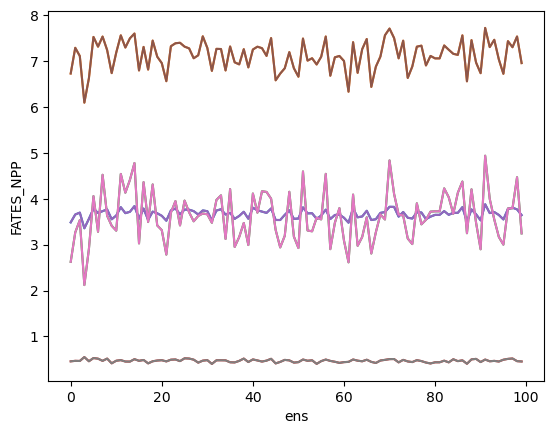

In [35]:
pftfit=1

accept_lai_i = []
accept_et_i = []
accept_gpp_i = []
accept_cue_i = []
accept_both_i = []

accept_lai_ens_i = []
accept_et_ens_i = []
accept_gpp_ens_i = []
accept_cue_ens_i = []
accept_both_ens_i = []


if(pftfit==1):
    for rfm in range(len(pfts)):        
        p=pfts[rfm]   
        print('pft',p)
        
        accept_et_i.append(find_acceptable_models(rfm,p,pftfit,0,enonan[:,gcells_pft[p]],1))
        accept_gpp_i.append(find_acceptable_models(rfm,p,pftfit,1,gnonan[:,gcells_pft[p]],1))      
        accept_lai_i.append(find_acceptable_models(rfm,p,pftfit,2,lnonan[:,gcells_pft[p]],1))
        accept_cue_i.append(find_acceptable_models(rfm,p,pftfit,3,cnonan[:,gcells_pft[p]],1))

        accept_et_ens_i.append(find_acceptable_models(rfm,p,pftfit,0,enonan[:,gcells_pft[p]],0))
        accept_gpp_ens_i.append(find_acceptable_models(rfm,p,pftfit,1,gnonan[:,gcells_pft[p]],0))
        accept_lai_ens_i.append(find_acceptable_models(rfm,p,pftfit,2,lnonan[:,gcells_pft[p]],0))
        accept_cue_ens_i.append(find_acceptable_models(rfm,p,pftfit,3
                                                       ,cnonan[:,gcells_pft[p]],0))
        
else: # gridcell fit  
    for rfm in range(len(gcells)):
        g=gcells[i]        
        accept_lai_i.append(find_acceptable_models(rfm,g,pftfit))  


### Draw selected parameter space

In [36]:
def draw_selected_param_space(rfm,p,pftfit,vtoggle):
    ncls=ncls_param
    if ncls==5: 
        tsz=16
        ysz=14
        xsz=14
        ht=16
        psz=9
    if ncls==4 :
        tsz=18
        ysz=18
        xsz=18
        ht=13
        psz=14
    #colors = plt.get_cmap('tab10').colors
    #colors = plt.get_cmap('CSS4_COLORS').colors

    # Choosing a specific color from the Tableau color palette
          
    axcount=0
    y_accept_lai=accept_lai_i[rfm]
    y_accept_et=accept_et_i[rfm]
    y_accept_gpp=accept_gpp_i[rfm]
    y_accept_cue=accept_cue_i[rfm]
    if(vtoggle==0):
        y_pred_noise  = y_pred_noise_i_et[rfm]
        fatesens=et_in.QFLX_EVAP_TOT[0:len(x_array)]
        vlab='ET'
    elif vtoggle==1:
        y_pred_noise  = y_pred_noise_i_gpp[rfm]
        fatesens=gpp_in.FATES_GPP[0:len(x_array)]
        vlab='GPP KgC/m2/year'

    elif vtoggle==2:
        y_pred_noise  = y_pred_noise_i_lai[rfm]
        fatesens=l.FATES_LAI[0:len(x_array)]
        vlab='LAI'
    elif vtoggle==3:
        y_pred_noise  = y_pred_noise_i_cue[rfm]
        fatesens=cuein.FATES_NPP[0:len(x_array)]
        vlab='GPP KgC/m2/year'

    Xsh=Xdense.shape
    rw=int(len(lhc_vars)/ncls)+1
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(22, ht)) 
    #pftname=sg_data['pft'].values[p].title()
    #fig.suptitle(pftname,fontsize=tsz,y=0.9)
    plt.subplots_adjust(wspace=0.15, hspace=0.35)  
    pftfit=1
    axcount=0
    print('minmax yprednoise',np.min(y_pred_noise),np.max(y_pred_noise))
    for v, var in enumerate(lhc_vars):  
        row = axcount //ncls
        col = axcount % ncls  
        axcount=axcount+1
        ap=0.7
        axes[row, col].scatter(Xdense[:,v], y_pred_noise, color=chosen_color_all,s=2)    
        axes[row, col].scatter(Xdense[y_accept_cue,v], y_pred_noise[y_accept_cue], color=chosen_color_cue,s=4, alpha=ap) 
        axes[row, col].scatter(Xdense[y_accept_et,v], y_pred_noise[y_accept_et], color=chosen_color_et,s=4, alpha=ap) 
        axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=4, alpha=ap)
        axes[row, col].scatter(Xdense[y_accept_lai,v], y_pred_noise[y_accept_lai], color=chosen_color_lai,s=4, alpha=ap) 

        # FATES runs
        #if vtoggle==0: # et on y axis            
            #axes[row, col].scatter(Xdense[y_accept_et,v], y_pred_noise[y_accept_et], color=chosen_color_et,s=8, alpha=ap) 
        #if vtoggle==1: # gpp on y axis            
        #    axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=6, alpha=ap) 
        #if vtoggle==2: # ;ai on y axis            
        #    axes[row, col].scatter(Xdense[y_accept_lai,v], y_pred_noise[y_accept_lai], color=chosen_color_lai,s=4, alpha=ap) 
        #if vtoggle==3: # ;ai on y axis            
        #    axes[row, col].scatter(Xdense[y_accept_cue,v], y_pred_noise[y_accept_cue], color=chosen_color_cue,s=3, alpha=ap) 
      
      #  elif(vtoggle==1):#lai on y axis
      #       axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=4) 
      #       axes[row, col].scatter(Xdense[y_accept_lai,v], y_pred_noise[y_accept_lai], color=chosen_color_lai,s=4) 
      #      axes[row, col].scatter(Xdense[y_accept_et,v], y_pred_noise[y_accept_et], color=chosen_color_et,s=4) 
      ##  elif(vtoggle==2):#gpp on y axis
      #      axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=4) 
      #  elif(vtoggle==3):#gpp on y axis
      #      axes[row, col].scatter(Xdense[y_accept_et,v], y_pred_noise[y_accept_et], color=chosen_color_et,s=4) 
      #      axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=4) 
      
        axes[row, col].scatter(x_array[:,v],  fatesens[:,gcells_pft[p]].mean(dim='gridcell'), s=psz, edgecolor='black',color='black')
        axes[row, col].set_xlabel(lhc_vars_title[v], fontsize=xsz)   
        if(col==0):
            axes[row, col].set_ylabel(vars_bm[vtoggle], fontsize=ysz)   
            
    while axcount < rw*ncls:
        row = axcount //ncls
        col = axcount %ncls
        axes[row, col].remove()
        axcount += 1

ip 0 0
minmax yprednoise 3.463102496975891 3.844573702973355
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC14_//emulator_and_ensemble_18_ET_p0.png


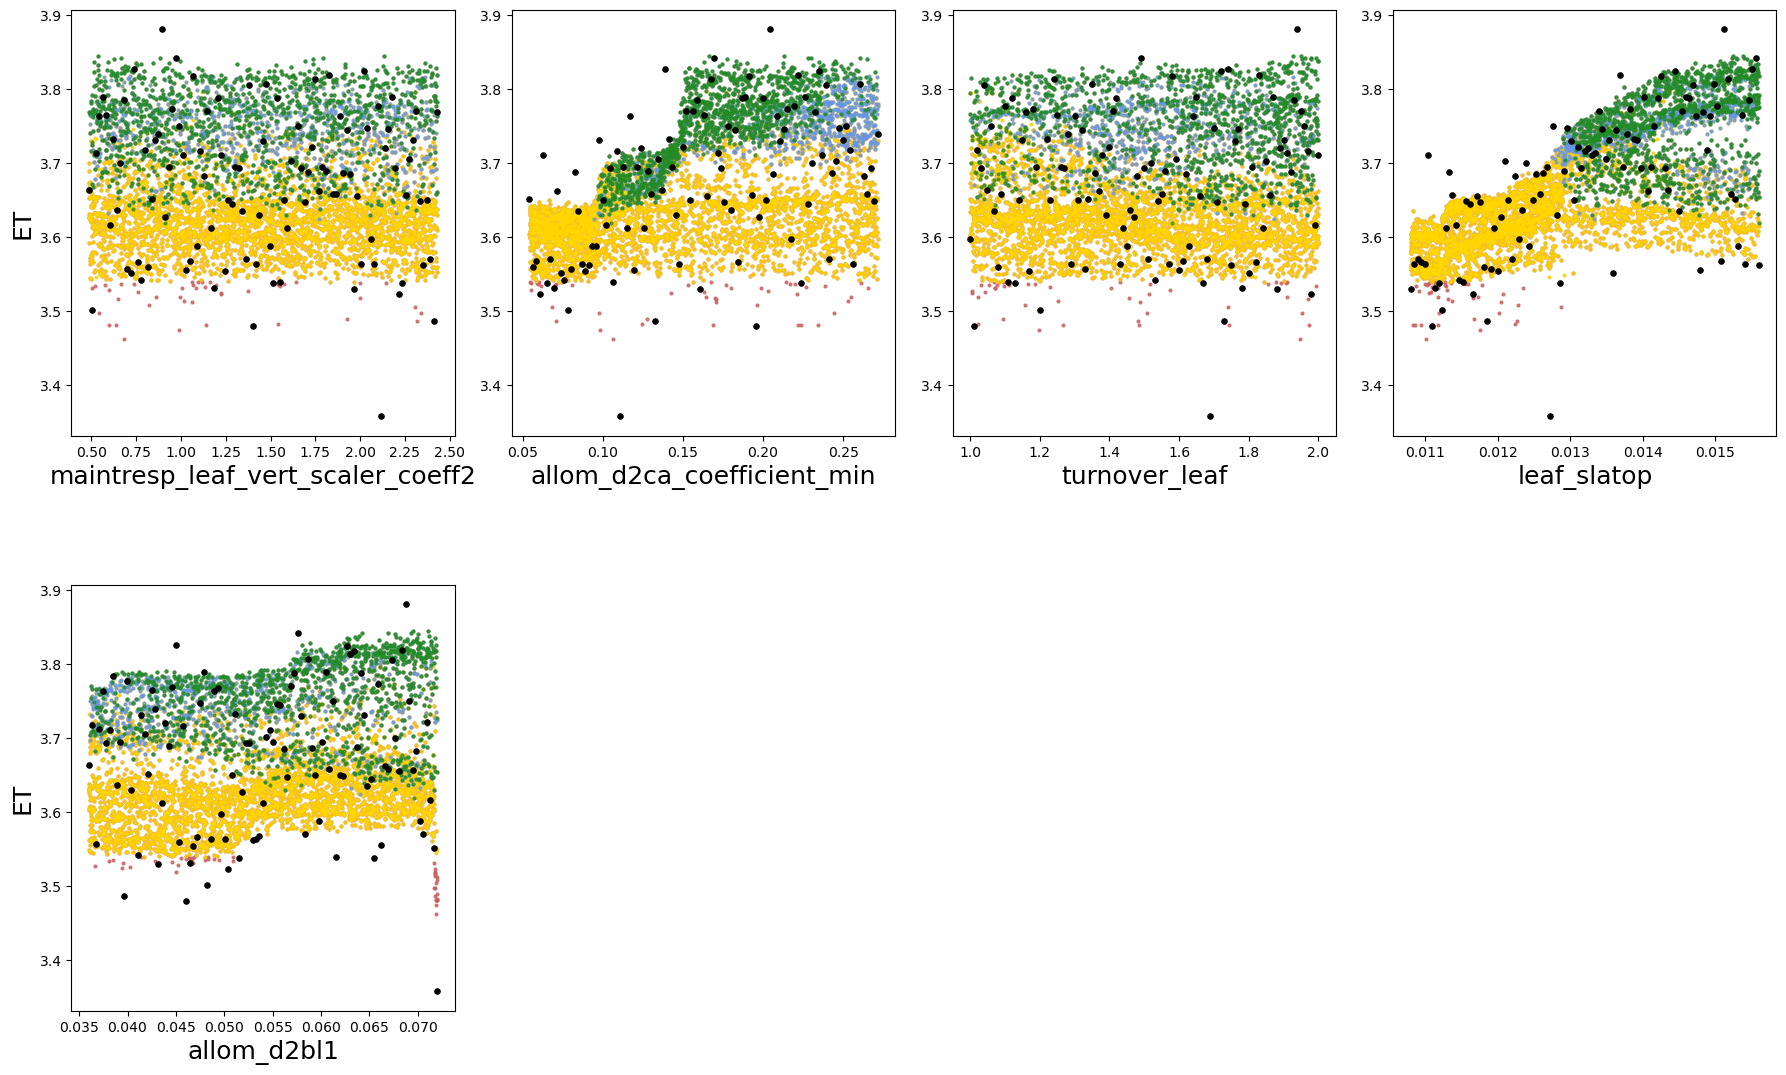

ip 0 0
minmax yprednoise 6.482892818457434 7.5856995204449085
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC14_//emulator_and_ensemble_18_GPP_p0.png


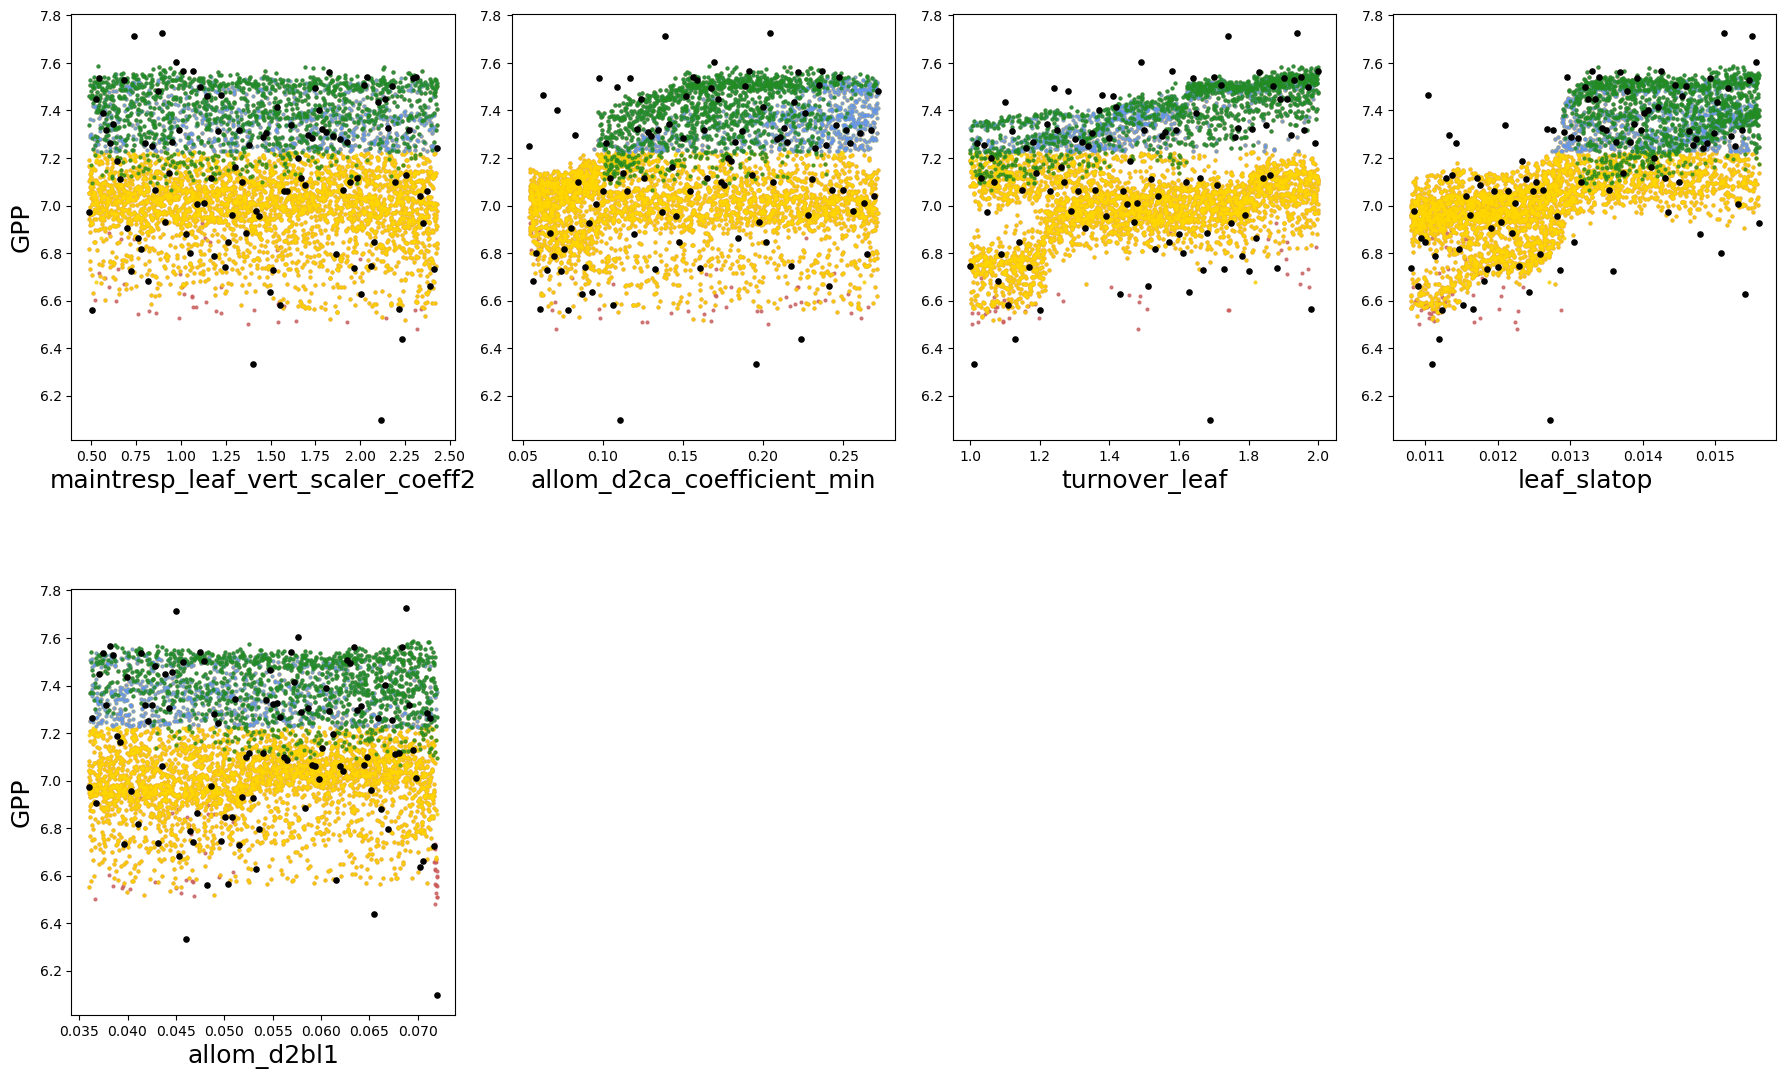

ip 0 0
minmax yprednoise 2.657167257660433 4.497467370624025
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC14_//emulator_and_ensemble_18_LAI_p0.png


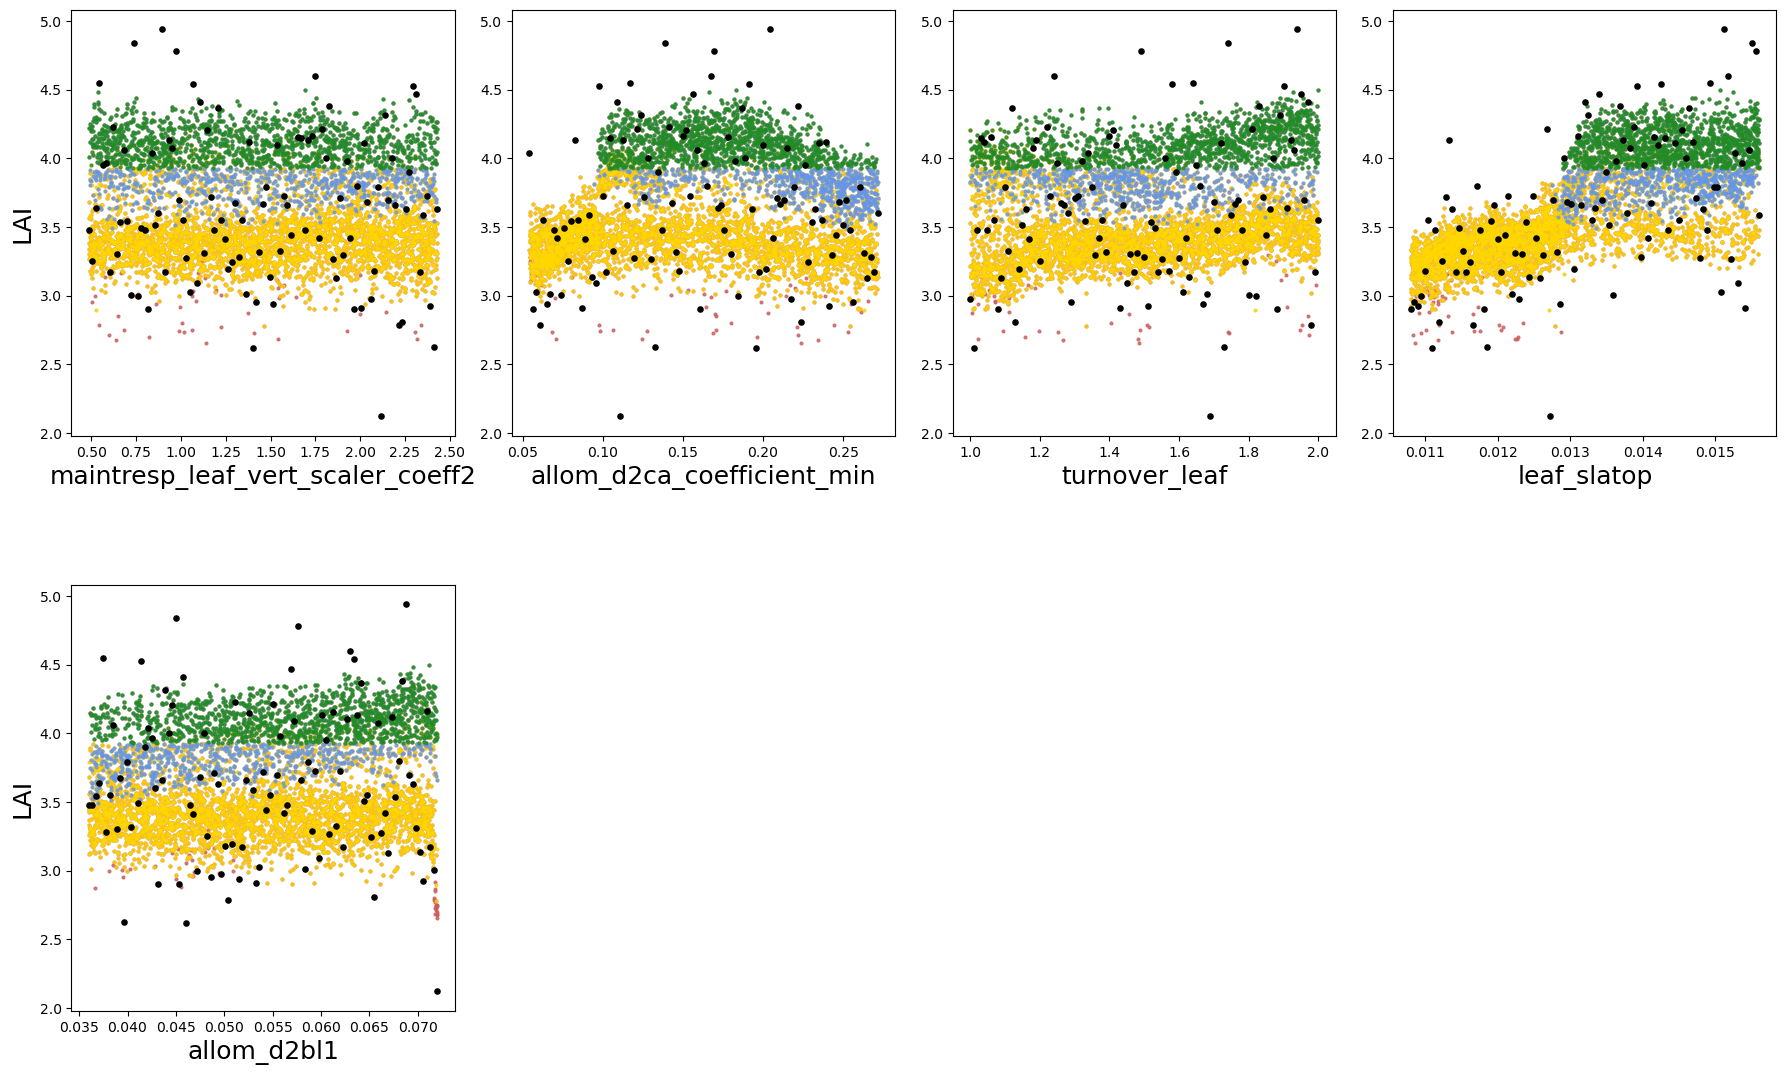

ip 0 0
minmax yprednoise 0.4216550061922791 0.5211879954632748
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC14_//emulator_and_ensemble_18_CUE_p0.png


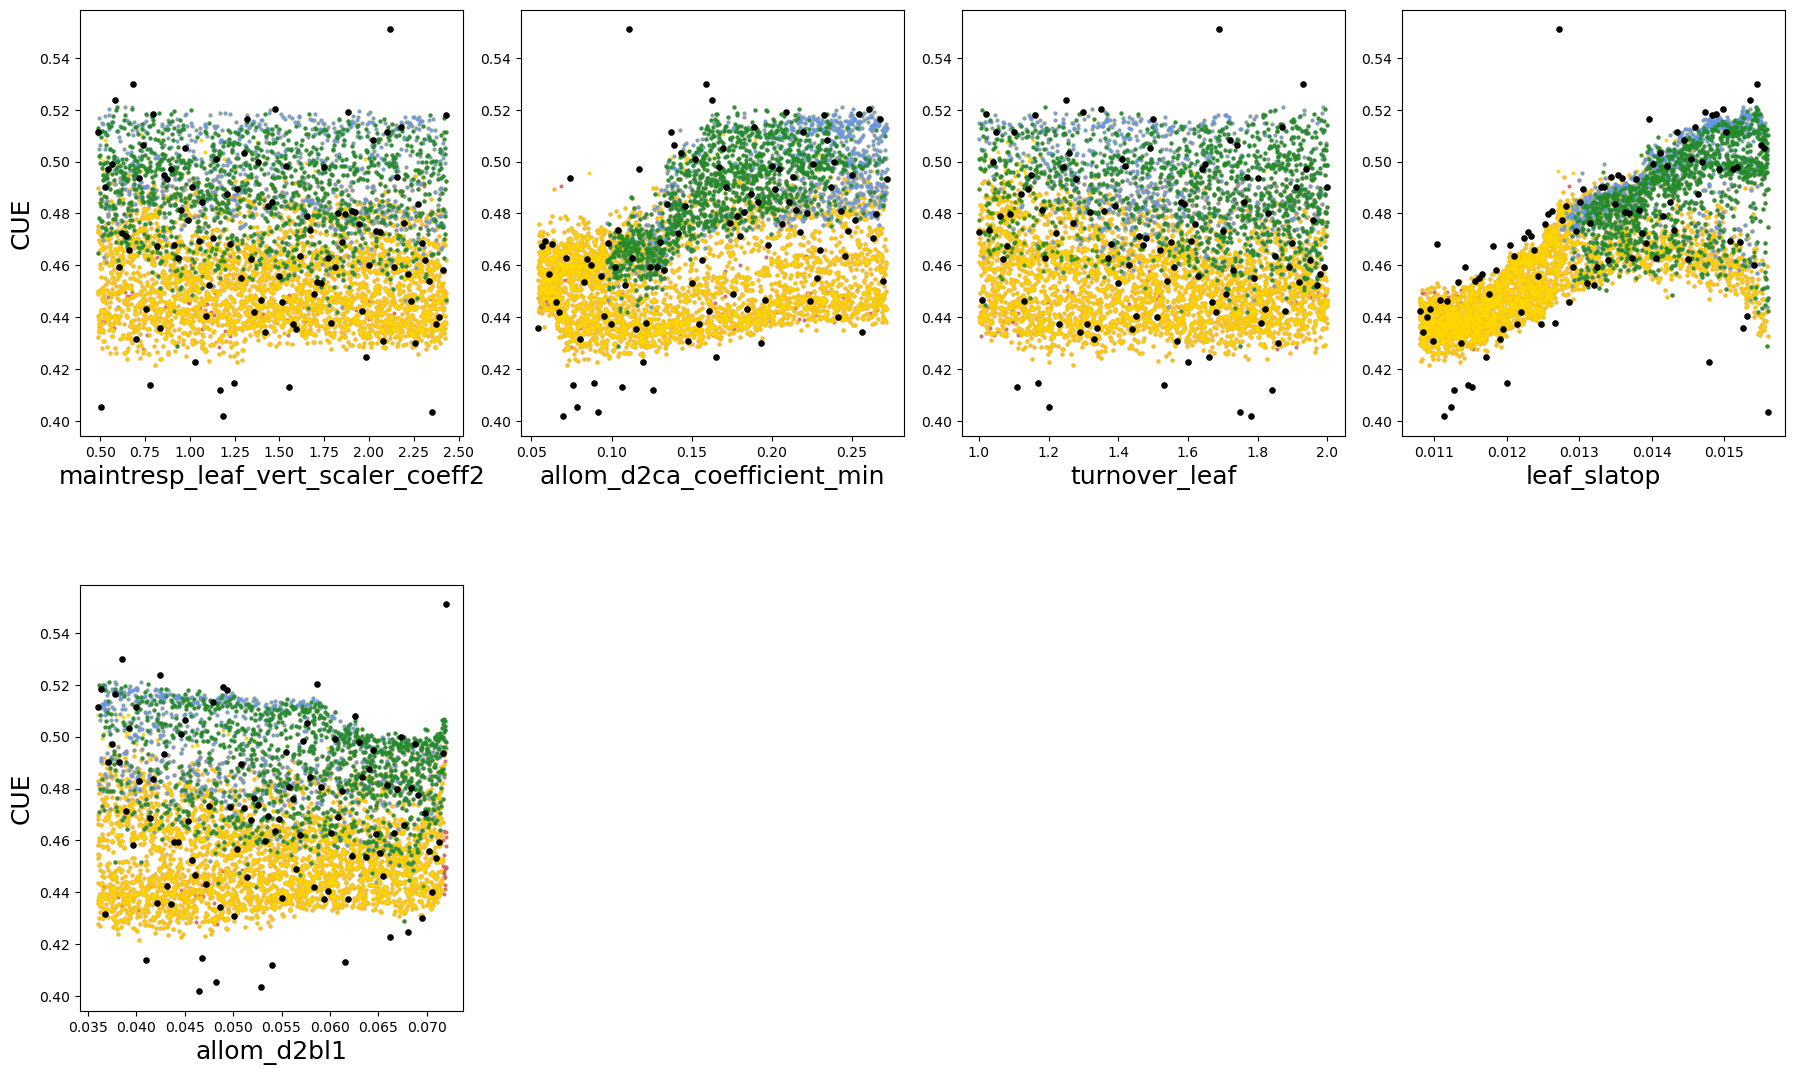

In [37]:
from matplotlib.colors import CSS4_COLORS

colors = plt.get_cmap('tab10').colors
# Choosing a specific color from the CSS4_COLORS dictionary
chosen_color_all = CSS4_COLORS['lightgrey']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_et = CSS4_COLORS['gold']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_lai = CSS4_COLORS['forestgreen']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_ens = CSS4_COLORS['darkblue']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_gpp = CSS4_COLORS['cornflowerblue']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_cue = CSS4_COLORS['indianred']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary

#chosen_color_all = colors[0]  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
#chosen_color_et = colors[1]   # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
#chosen_color_lai = colors[4]   # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
#chosen_color_ens = colors[5]  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary

if pftfit==1:
    for i in range(len(pfts)):
        for vtoggle in [0,1,2,3]:
            p = pfts[i]
            gcells=gcells_pft[p]
            print('ip',i,p)
            draw_selected_param_space(i,p,pftfit,vtoggle)   
    
            figname=figdir+'/emulator_and_ensemble_'+str(ensN)+'_'+vars_bm[vtoggle]+'_p'+str(p)+'.png'
            print(figname)
            plt.savefig(figname, bbox_inches='tight')
            plt.show() 
else:
    for i in range(len(gcells_pft[p])):
        g=gcells[i] 
        print(g,i)
        draw_selected_param_space(g,i,pftfit)

### Plot out simple parameter distributions

(1154,)
(1300,)


(array([ 48., 116.,  90., 121., 113., 138., 115., 120., 132., 161.]),
 array([0.01289514, 0.01316563, 0.01343611, 0.0137066 , 0.01397708,
        0.01424757, 0.01451806, 0.01478854, 0.01505903, 0.01532951,
        0.0156    ]),
 <BarContainer object of 10 artists>)

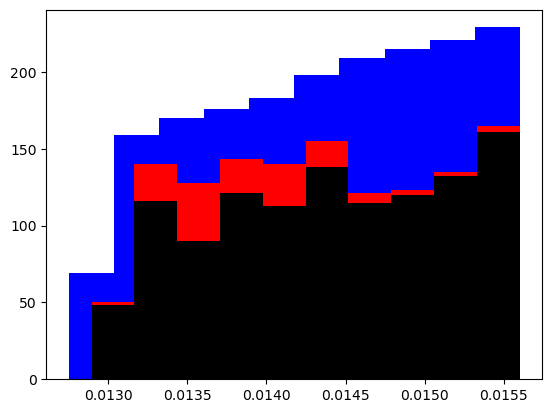

In [38]:
i=0
accept_lai=accept_lai_i[i]
accept_gpp=accept_gpp_i[i]   
accept_et=accept_et_i[i] 
accept_cue=accept_cue_i[i] 
common_values = np.intersect1d(accept_lai, accept_gpp)
print(np.shape(common_values))
p=0
xv=feat_importance[p,0,1]
xsl=np.squeeze( Xdense[accept_lai,xv])
xsc=np.squeeze( Xdense[accept_gpp,xv])
xscv=np.squeeze( Xdense[common_values,xv])

print(np.shape(xsl))
plt.hist(xsc,color='blue')
plt.hist(xsl,color='red')
plt.hist(xscv,color='black')


### Make function to plot 3D space

In [39]:
def plot_3d_param_space(i,g,v,ch):
    accept_et=accept_et_i[i]
    accept_gpp=accept_gpp_i[i]   
    accept_lai=accept_lai_i[i] 
    accept_cue=accept_cue_i[i] 
    common_values1 = np.intersect1d(accept_et, accept_gpp)
    common_values2 = np.intersect1d(common_values1, accept_lai)
    common_values3 = np.intersect1d(common_values2, accept_cue)
    
    if(v==2):
        vf=0
    else:
        vf=v
    vf=2
    print(np.shape(accept_gpp),np.shape(accept_et))
    xv=feat_importance[i,0,vf]
    yv=feat_importance[i,1,vf]
    zv=feat_importance[i,2,vf]
    cv=feat_importance[i,3,vf]

    xsg = Xdense[accept_et,xv]
    ysg = Xdense[accept_et,yv]
    zsg = Xdense[accept_et,zv]
    csg = Xdense[accept_et,cv]
    
    xse = Xdense[accept_gpp,xv]
    yse = Xdense[accept_gpp,yv]
    zse = Xdense[accept_gpp,zv]
    cse = Xdense[accept_gpp,cv]

    xsc1 = Xdense[common_values1,xv]
    ysc1 = Xdense[common_values1,yv]
    zsc1 = Xdense[common_values1,zv]
    csc1 = Xdense[common_values1,cv]

    xsc2 = Xdense[common_values,xv]
    ysc2 = Xdense[common_values,yv]
    zsc2 = Xdense[common_values,zv]
    csc2 = Xdense[common_values,cv]

    xsc3 = Xdense[common_values,xv]
    ysc3 = Xdense[common_values,yv]
    zsc3 = Xdense[common_values,zv]
    csc3 = Xdense[common_values,cv]    

    
    if(ch==1):
        xsch = Xdense[chosen_values_i[i],xv]
        ysch = Xdense[chosen_values_i[i],yv]
        zsch = Xdense[chosen_values_i[i],zv]
        csch = Xdense[chosen_values_i[i],cv]
        
    xsd = Xdense[:,xv]
    ysd = Xdense[:,yv]
    zsd = Xdense[:,zv]

    if(v==0): # GPP
        plt3d=ax.scatter(xsc1,  ysc1,  zsc1,s=4, c=chosen_color_gpp, alpha=1,label='GPP & ET constraint')
    elif v==1: #GPP
        plt3d=ax.scatter(xsc2,  ysc2,  zsc2,  s=8,c=chosen_color_et, alpha=1,label='+LAI constraint')
        #plt3dl=axes[row,col].scatter(xsl,  ysl,  zsl,  s=8,c=chosen_color_lai, alpha=0.7,label='LAI constraint')
    elif v==2:
        plt3d=ax.scatter(xsc3,  ysc3,  zsc3,  s=8,c='black', alpha=0.7,label='+CUE constraint')
        #plt3dl=axes[row,col].scatter(xsl,  ysl,  zsl,  s=8,c=chosen_color_lai, alpha=0.7,label='LAI constraint')
    if(ch==1):# plot chosen values
        plt3d=ax.scatter(xsch,  ysch,  zsch,  s=18,c='red', alpha=0.7,label='chosen points')
        
        
    fsa=14
    fst=16
    ax.set_xlabel(lhc_vars_title[xv],fontsize=fsa,labelpad=12)
    ax.set_ylabel(lhc_vars_title[yv],fontsize=fsa,labelpad=12)
    ax.set_zlabel(lhc_vars_title[zv],fontsize=fsa)
    #axes[row,col].set_title(pftname,fontsize=fst)   

    return [plt3d]

### Plot the 3D space for each PFT average calibration

v 0
(1, 1829) (1, 4954)


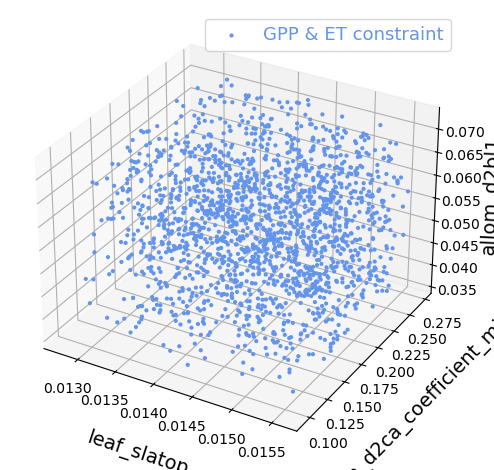

v 1
(1, 1829) (1, 4954)


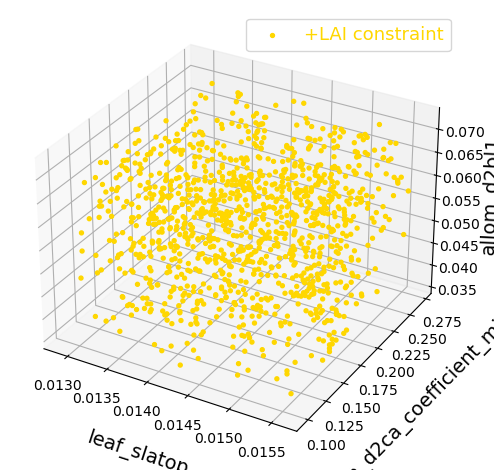

v 2
(1, 1829) (1, 4954)


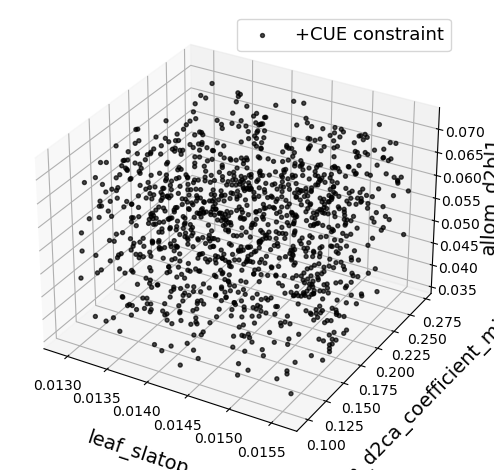

In [40]:

for v in [0,1,2]:
    fig = plt.figure()
    print('v',v)
    ax = fig.add_subplot(111, projection='3d')
    if(v<2): 
        figv=vars_bm[v]
        if(v==0):
            chosen_color=chosen_color_gpp
        else:
            chosen_color=chosen_color_et           
    else:
        figv='GPP and ET'
        chosen_color='black'
    if(pftfit==1):
        p=0 
        i=0
        hnd=plot_3d_param_space(i,p, v,0)
        
    legend=ax.legend(handles=hnd,fontsize=13)  # Place the legend in the upper right corner            
    #axes[ rw-1,ncls-1].axis('off')
    for text in legend.get_texts():
        text.set_color(chosen_color)
 #   while axcount < rw*ncls:
 #       row = axcount //ncls
 #       col = axcount %ncls
 #       axes[row, col].remove()
 #       axcount += 1  
    plt.tight_layout()
    plt.savefig(figdir+'/PFT_3D_plot_e'+str(ensN)+'_'+figv+'.png', bbox_inches='tight')
    plt.show()

### Choose some members of the selected parameter space. 

#### Create an array of the common values

In [41]:
import random 

chosen_values_i =[]
for i in range(len(pfts)):
    p=pfts[i]
    accept_gpp=accept_gpp_i[i]
    accept_et=accept_et_i[i]   
    common_values_p = np.intersect1d(accept_gpp, accept_et)
    print(np.shape(accept_gpp),np.shape(accept_et))
    if(np.size(common_values_p) >= 10):
        random_values = random.sample(sorted(common_values_p), 10)  
    else:
        random_values=[1]
    chosen_values_i.append(random_values)
    print(i,p,chosen_values_i[i])
    #choose ten values at random from the common values

print(chosen_values_i)

(1, 1829) (1, 4954)
0 0 [3270, 2347, 4764, 3873, 1525, 1681, 3056, 1747, 2869, 3629]
[[3270, 2347, 4764, 3873, 1525, 1681, 3056, 1747, 2869, 3629]]


### For each output ensemble member, loop round parameters and change their values

In [42]:
print(make_params)
poutfiles=[]

if make_params==1:
    noutput_files=10
    print('nf',noutput_files)
    pfile1= pfileroot+str(1)+'.nc'
    
    pfile1='../nocomp_parameter_modification_python/intermediate_pfiles/modified_average_file2.nc'
    tag_pfile_crops=ppe_root+'/nocomp_parameter_modification_python/intermediate_pfiles/fates_params_vertsc_dayl_crops.nc'
    pout=ppe_root+'/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC_calibrated_files/NOCOMP_calib_'

    pf=xr.open_dataset(tag_pfile_crops)
    print('tagfile',tag_pfile_crops)
    for v, var in enumerate(lhc_vars):
        if(pf[var].ndim==1):
            print(var,pf[var][0].values)
        else:
            print(var,pf[var][0,0].values) 
    for f in range(noutput_files):
        newfile =pout+'ens'+str(ensN)+'_n'+str(f)+'.nc'
        
        print('nfile',f)
        for v, var in enumerate(lhc_vars):
            
            dms=pf[var].dims
            ndms=pf[var].ndim
            for i in range(len(pfts)):
                pft = pfts[i]

                # the variable is a PFT specific value
                # so we need to apply it to eaach PFT
                # but it is defined in the SPACE OF THE 1st PFT (TrEB) 
                nxd=chosen_values_i[i][f] # for each PFT (i) and file (f)
                varnew=Xdense[nxd,v] # Find the p1 parameter corresponding
                print(f,'var,varnew',var,varnew)
                # decide whether this parameter needs PFT scaling       
                if ndms == 0: # one dimensional variable
                    print('0d var', pft,var,varnew)   
                    # do not alter the 0 dimensional variables!
                    #with PFT specific tuning. 
                else: 
                    #print('1d var', var)           
                    #calculate min and max for this parameter
                    param_min=all_param_data[var].min('ens').values
                    param_max=all_param_data[var].max('ens').values
                    param_min_av=np.mean(param_min) #across PFTs
                    param_max_av=np.mean(param_max)
                    delta_p0=(varnew-param_min_av)/(param_max_av-param_min_av)
                    #print('delta',delta_p0,varnew,param_min_av,param_max_av)
                    # `this is the deviation that the first parameter would have in the 
                    #   hypothetical parameter file consistant with this emulated point
                    # For THIS PFT find define the corrsponding value
                    if( ndms == 1):
                        newvalue_PFT=param_min[pft]+delta_p0*(param_max[pft]-param_min[pft])
                        pf[var][pft]=varnew
                        #print('1d var', var,newvalue_PFT) 
                    elif ndms == 2: 
                        #print('2d var', var)  
                        newvalue_PFT=param_min[:,pft]+delta_p0*(param_max[:,pft]-param_min[:,pft])
                        pf[var][:,pft]=varnew
                print('pfvar',pf[var].values)
            #print('var to modf',var,pf[var].values)
        print(newfile)
        poutfiles.append(newfile)       
        pf.to_netcdf(newfile)
        pf.close()


1
nf 10
tagfile /glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/intermediate_pfiles/fates_params_vertsc_dayl_crops.nc
fates_maintresp_leaf_vert_scaler_coeff2 2.43
fates_allom_d2ca_coefficient_min 0.2715891
fates_turnover_leaf 1.5
fates_leaf_slatop 0.012
fates_allom_d2bl1 0.04
nfile 0
0 var,varnew fates_maintresp_leaf_vert_scaler_coeff2 1.4826937387477497
pfvar [1.48269374 2.43       2.43       2.43       2.43       2.43
 2.43       2.43       2.43       2.43       2.43       2.43      ]
0 var,varnew fates_allom_d2ca_coefficient_min 0.1160352069973995
pfvar [0.11603521 0.3693718  1.0787259  0.0579297  0.2715891  1.1553612
 0.6568464  0.6568464  0.6568464  0.6568464  0.6568464  0.6568464 ]
0 var,varnew fates_turnover_leaf 1.7881576315263052
pfvar [[1.78815763 4.         1.         1.5        1.         1.
  1.5        1.         1.         1.         1.         1.        ]]
0 var,varnew fates_leaf_slatop 0.014200040008001602
pfvar [0.014200

In [43]:
#for f in range(noutput_files):
f=1
for f in range(noutput_files):
    
    pf=xr.open_dataset(poutfiles[f])
    print(poutfiles[f])
    for v, var in enumerate(lhc_vars):
        if(pf[var].ndim==1):
            print(var,pf[var][0].values)
        else:
            print(var,pf[var][:,0].values)
    pf.close()

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC_calibrated_files/NOCOMP_calib_ens18_n0.nc
fates_maintresp_leaf_vert_scaler_coeff2 1.4826937387477497
fates_allom_d2ca_coefficient_min 0.1160352069973995
fates_turnover_leaf [1.78815763]
fates_leaf_slatop 0.014200040008001602
fates_allom_d2bl1 0.06223484696939388
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC_calibrated_files/NOCOMP_calib_ens18_n1.nc
fates_maintresp_leaf_vert_scaler_coeff2 1.4294174834966995
fates_allom_d2ca_coefficient_min 0.18427203628325667
fates_turnover_leaf [1.19963993]
fates_leaf_slatop 0.014866413282656532
fates_allom_d2bl1 0.05071974394878977
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC_calibrated_files/NOCOMP_calib_ens18_n2.nc
fates_maintresp_leaf_vert_scaler_coeff2 2.012345269053811
fates_allom_d2ca_co